# IMEC2201 Herramientas Computacionales 
## Semana 8: Transformada Rápida de Fourier (FFT)
### Clase 14: Aplicación FFT: Dinámica

Universidad de los Andes — Mayo 25, 2022.

---

## TABLA DE CONTENIDO

### Sección 1: FFT a Sistemas Dinámicos [→](#section1)
- 1.1. Introducción
- 1.2. Cargar Librerías
- 1.3. Ejemplo 1
- 1.4. Ejemplo 2
- 1.5. Ejemplo 3
- 1.6. Ejemplo 4
- 1.7. Ejemplo 5
___

**¡Importante!** Note que la carpeta **week8** contiene dos archivos: `Project.toml` y `Manifest.toml`. Estos configuran el <font color="#FF5733">*ambiente de trabajo*</font> y facilitan el manejo de <font color="#FF5733">librerías</font>.

Para inicializar el ambiente desde Julia REPL, dentro de la carpeta **week8**, ejecute lo siguiente:

```shell
$ (v1.7) pkg > activate .
$ (week8) pkg> instantiate
```

**Nota:** Para acceder al Pkg REPL, escriba el corchete derecho `]` en el Julia REPL. Note que el REPL cambie de color de verde (Julia REPL) a azul (Pkg REPL). Una vez ejecutado el código `activate .`, el prefijo entre paréntesis indica el ambiente activo: cambia de `v1.7` a `week8`.

O, desde Jupyter Notebook, ejecute:

```julia
$ using Pkg
$ Pkg.activate()
$ Pkg.instantiate()
```

**Nota:** La activación del ambiente <font color="#FF5733">*precompila*</font> las librerías por lo que puede tardar un momento su ejecución completa.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
Puede obtener más información en la documentación oficial de la librería [`Pkg.jl`](https://pkgdocs.julialang.org/v1/environments/) y en el documento dando clic [aquí](https://towardsdatascience.com/how-to-setup-project-environments-in-julia-ec8ae73afe9c).
</div>

In [1]:
using Pkg
Pkg.activate(pwd())
Pkg.instantiate()

  Activating project at `~/Documents/GitHub/ua-imec2001-hc-202210/content/week8`


In [2]:
Pkg.status()

      Status `~/Documents/GitHub/ua-imec2001-hc-202210/content/week8/Project.toml`
  [336ed68f] CSV v0.10.4
  [717857b8] DSP v0.7.5
  [a93c6f00] DataFrames v1.3.4
  [0c46a032] DifferentialEquations v7.1.0
  [7a1cc6ca] FFTW v1.4.6
  [91a5bcdd] Plots v1.29.0
  [8149f6b0] WAV v1.2.0
  [fdbf4ff8] XLSX v0.7.10


<a id="section1"></a>
# Sección 1: FFT a Sistemas Dinámicos

## 1.1. Introducción

Tengamos presentes las siguientes equivalencias:

#### Movimiento Rectilíneo
$$
\begin{cases}
  v = \frac{dx}{dt} = \dot{x} \\ 
  \\
  a = \frac{dv}{dt} = \frac{d}{dt} \left( \frac{dx}{dt} \right) = \frac{d^2x}{dt^2} = \ddot{x} \\
\end{cases} 
$$

#### Movimiento Rotacional
$$
\begin{cases}
  \omega = \frac{d \theta}{dt} = \dot{\theta} \\ 
  \\
  \alpha = \frac{d \omega}{dt} = \frac{d}{dt} \left( \frac{d \theta}{dt} \right) = \frac{d^2 \theta}{dt^2} = \ddot{\theta} \\
\end{cases} 
$$

#### Generalización 2da Ley de Newton
$$
\begin{cases}
  F = ma \rightarrow F = m \ddot{x} & (1) \\ 
  \\
  T = I \alpha \rightarrow T = I \ddot{\theta} & (2) \\
\end{cases} 
$$

Siendo $F$ la fuerza, $m$ la masa, $a$ la aceleración, $T$ el torque, $I$ el momento de inercia (en nuestros casos de estudio, $I = m L^2$, siendo $L$ la longitud al punto de pivote del giro) y $\theta$ el ángulo de giro.

Aprovecharemos la librería `DifferentialEquations.jl` para dar respuesta a ejercicios de dinámica de manera práctica y eficiente.

También, aprovecharemos la librería `FFT.jl` para comprender de forma práctica y eficiente qué es la FFT y cómo la podemos aplicar al trabajar con el comportamiento de propiedades dinámicas de sistemas en el tiempo.

¡Empecemos!

## 1.2. Cargar Librerías

In [3]:
using DifferentialEquations
using DataFrames
using Plots
using FFTW
using XLSX
using CSV
using WAV
using DSP

## 1.3. Ejemplo 1: Péndulo Simple

<img src='./img/pendulum1.png' width='300' height='300'/>

Partimos de la relación:

$$
T = I \ddot{\theta}
$$

El único componente de la masa que causa un torque en el cuerpo es:

$$
m g \sin \theta
$$

Luego:

$$
\boxed{ \ddot{\theta} + \frac{g}{L} \sin \theta = 0 }
$$

**Nota**: Ejercicio tomado de [aquí](https://www.youtube.com/watch?v=8VJ1CJ55Np0). Este [otro video](https://www.youtube.com/watch?v=xBBXlQ7CmFc) puede apoyar la comprensión del desarrollo.

Modelemos esta ODE de segundo grado para:

- $g = 9.81$
- $L = 5.0$
- $du(t=0) = du_0 = 0$
- $u(t=0) = u_0 = 30$
- $t_{inicial} = 0$
- $t_{final} = 200$

Donde:
- $du$ es la derivada de $u$
- $u$ es la variable que se está resolviendo en estado actual
- $p$ es el parámetro que contiene las variables parametrizadas
- $t$ es el tiempo actual

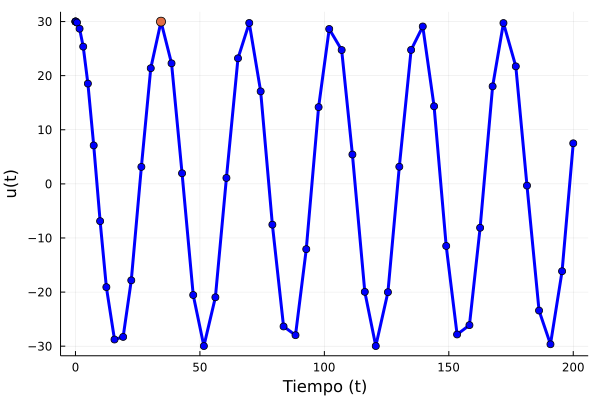

In [4]:
# Paso 1. Definir el problema
penduloSimple!(du,u,p,t) = -(g/L) * sind(u)

# Constantes
g = 9.81
L = 5.0

# Parámetros
du0 = 0.0
u0 = 30.0
tspan = (0.0, 200.0)

prob = SecondOrderODEProblem(penduloSimple!, du0, u0, tspan)

# Paso 2. Resolver el problema
sol = solve(prob)

# Paso 3. Analizar la solución
du_sol = [u[2] for u in sol.u]

dom_tiempo = plot(sol.t,
                  du_sol,
                  seriestype=:line,
                  title="",
                  xlabel="Tiempo (t)",
                  ylabel="u(t)",
                  linewidth=3,
                  color=:blue,
                  marker=:circ,
                  label="Solución Numérica",
                  legend=false)

plot!(dom_tiempo, [sol.t[17]], [du_sol[17]], seriestype=:scatter, m=:circle, ms=5, label="Periodo")

In [5]:
# FFT
# Periodo
T = sol.t[17] # ms

# Cantidad de datos
N = length(du_sol)

# Frecuencia de muestreo
function frec_muestreo(T)
    return 1/T
end

Δf = frec_muestreo(T) # Hz
println("Frecuencia Muestreo: $(Δf) Hz")

# Frecuencia Circular
function freq_circular(T)
    return 2*π / (T/1000)
end

ω = freq_circular(T) # rad/s
println("Frecuencia Circular: $(ω) rad/s")

Frecuencia Muestreo: 0.029099668611094948 Hz
Frecuencia Circular: 182.8386102610268 rad/s


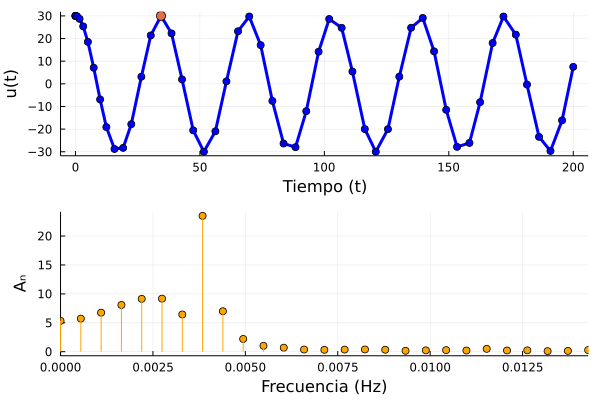

In [6]:
señal = convert(Array{Float64,1}, du_sol) # Any a Float64
señal_fft = fft(señal)

frecs = fftfreq(N, Δf)
Aₙ = (2/N).*abs.(señal_fft)

dom_frec = plot(frecs,
                Aₙ,
                seriestype=:line,
                line=:stem,
                xlabel="Frecuencia (Hz)", 
                ylabel="Aₙ",
                xlim=(0, max(frecs...)),
                legend=false,
                c=:orange,
                m=:circle,
                ms=4)

plot(dom_tiempo, dom_frec, layout=(2,1))

In [7]:
# N-pico de frecuencia máxima
n_pico = argmax(Aₙ)-1
n_pico

7

In [8]:
# Amplitudes
max_Aₙ = unique(sort(Aₙ, rev=true))[1:n_pico]
max_Aₙ

7-element Vector{Float64}:
 23.481323555723126
  9.173950724425287
  9.173950724425284
  9.137962560561782
  9.13796256056178
  8.077662524394873
  8.07766252439487

In [9]:
# Ángulos de Fase
ϕ = unique(sort(angle.(señal_fft), rev=true))[1:n_pico]
ϕ

7-element Vector{Float64}:
 2.731909312967166
 2.472434601337088
 1.6957945499053442
 1.4190623991134272
 1.288069240958225
 1.0617497868864867
 1.0201120995703605

Conocidos estos valores, podemos obtener la representación matemática de la DFT; para el armónico principal, esta es:

$$
\boxed{ f(t) = 23.48 \sin(7 \omega t + 2.73) }
$$

## 1.4. Ejemplo 2: Péndulo Simple + Fricción + Fuerza Externa

<img src='./img/pendulum2.png' width='800' height='800'/>

Este caso es una extensión al Ejemplo 1, pues:

$$
F = m a
$$

Luego:

$$
F_0 \cos(\omega t) - mg \sin(\theta) - c \frac{ds}{dt} = ma 
$$

Entonces:

$$
F_0 \cos(\omega t) = m L \ddot{\theta} + c L \dot{\theta} + mg \sin(\theta)
$$

Que se puede reescribir como:

$$
\boxed{ \ddot{\theta} + \alpha \dot{\theta} + \sin(\theta) = \gamma \cos(\beta t) }
$$

Donde:

$$
\begin{cases}
  \alpha = \frac{c}{m \omega_0} \\ 
  \\
  \beta = \frac{\omega}{\omega_0} \\
  \\
  \gamma = \frac{F_0}{m L \omega_0^2}
\end{cases} 
$$

**Nota**: Ejercicio tomado de [aquí](https://www.youtube.com/watch?v=SZWn7x4g-Vo).

Modelemos esta ODE de segundo grado para:

- $c = 0.5$
- $m = 2$
- $\omega_0 = 50$
- $\beta = 0.98$
- $F_0 = 150$
- $L = 8$
- $du(t=0) = du_0 = 0$
- $u(t=0) = u_0 = 30$
- $t_{inicial} = 0$
- $t_{final} = 1000$

Donde:
- $du$ es la derivada de $u$
- $u$ es la variable que se está resolviendo en estado actual
- $p$ es el parámetro que contiene las variables parametrizadas
- $t$ es el tiempo actual

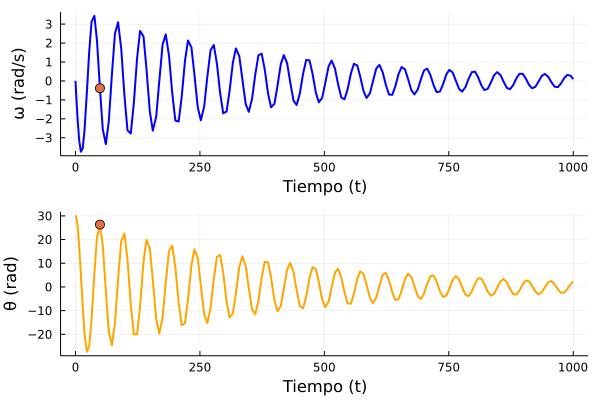

In [10]:
# Paso 1. Definir el problema
penduloFriccionFuerza!(du,u,p,t) = -p[1]*du - sind(u) + p[3]*cosd(p[2]*t) # Juan Sabogal

# Constantes
c = 0.5
m = 2.0
ω₀ = 50.0
β = 0.98
F₀ = 150
L = 8.0

α = c / (m*ω₀)
γ = F₀ / (m*L*(ω₀^2))

# Parámetros
du0 = 0.0
u0 = 30.0
tspan = (0.0, 1000.0)
p = [α, β, γ]

prob = SecondOrderODEProblem(penduloFriccionFuerza!, du0, u0, tspan, p)

# Paso 2. Resolver el problema
sol = solve(prob)

# Paso 3. Analizar la solución
du_sol = [u[1] for u in sol.u]
u_sol = [u[2] for u in sol.u]

ω_tiempo = plot(sol.t,
                du_sol,
                linewidth=2,
                xlabel="Tiempo (t)",
                ylabel="ω (rad/s)",
                color="blue",
                legend=false)

θ_tiempo = plot(sol.t,
                u_sol,
                linewidth=2,
                xlabel="Tiempo (t)",
                ylabel="θ (rad)",
                color="orange",
                legend=false)


plot!(ω_tiempo, [sol.t[17]], [du_sol[17]], seriestype=:scatter, m=:circle, ms=5)
plot!(θ_tiempo, [sol.t[17]], [u_sol[17]], seriestype=:scatter, m=:circle, ms=5)

dom_tiempo = plot(ω_tiempo, θ_tiempo, layout=(2,1))

In [11]:
# FFT
# Periodo
T = sol.t[17] # ms

# Cantidad de datos
N = length(du_sol)

# Frecuencia de muestreo
Δf = frec_muestreo(T) # Hz
println("Frecuencia Muestreo: $(Δf) Hz")

# Frecuencia Circular
ω = freq_circular(T) # rad/s
println("Frecuencia Circular: $(ω) rad/s")

Frecuencia Muestreo: 0.020346417083462208 Hz
Frecuencia Circular: 127.84030887255746 rad/s


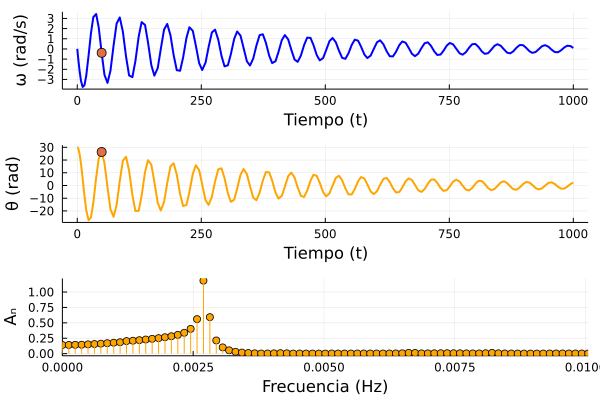

In [12]:
señal = convert(Array{Float64,1}, du_sol) # Any a Float64
señal_fft = fft(señal)

frecs = fftfreq(N, Δf)
Aₙ = (2/N).*abs.(señal_fft)

dom_frec = plot(frecs,
                Aₙ,
                seriestype=:line,
                line=:stem,
                xlabel="Frecuencia (Hz)", 
                ylabel="Aₙ",
                xlim=(0, max(frecs...)),
                legend=false,
                c=:orange,
                m=:circle,
                ms=4)

plot(ω_tiempo, θ_tiempo, dom_frec, layout=(3,1))

In [13]:
# N-pico de frecuencia máxima
n_pico = argmax(Aₙ)-1
n_pico

22

In [14]:
# Amplitudes
max_Aₙ = unique(sort(Aₙ, rev=true))[1:n_pico]
max_Aₙ

22-element Vector{Float64}:
 1.1841225903991301
 0.5917953286669966
 0.5917953286669964
 0.559832234503295
 0.5598322345032949
 0.4016607563908304
 0.3381928138646673
 0.3381928138646672
 0.3047237492235245
 0.30472374922352446
 0.28172174553219964
 0.2659350698719611
 0.2659350698719609
 0.2510041372408977
 0.24004820529028217
 0.22858724715132347
 0.22858724715132342
 0.218247890778854
 0.21824789077885393
 0.21338865745843005
 0.21338865745842991
 0.20931211483318515

In [15]:
# Ángulos de Fase
ϕ = unique(sort(angle.(señal_fft), rev=true))[1:n_pico]
ϕ

22-element Vector{Float64}:
 3.1415926535897736
 3.1044122500929943
 3.098764836491675
 3.0506430454594433
 3.0183133166679315
 2.9722741504787913
 2.908191988675715
 2.906507714212644
 2.861389033613225
 2.7131771375432994
 2.6948399791866673
 2.6819788546848384
 2.6779357206652334
 2.646389260321845
 2.620748642849148
 2.608290027634076
 2.5465523723603485
 2.5221258803650626
 2.5004983420777123
 2.464050515588554
 2.451384800971775
 2.4209621463891002

## 1.5. Ejemplo 3: Masa-Resorte

<img src='./img/spring1.png' width='800' height='800'/>

El escenario de una masa-resorte parte de:

$$
F = m a = m \ddot{x}
$$

En donde se tienen los siguientes elementos presentes:

$$
\begin{cases}
  \text{Ley de Hooke} \rightarrow F_s = -k x \\ 
  \\
  \text{Fricción} \rightarrow \beta = F_f = -c \frac{dx}{dt} = -c \dot{x} \\
  \\
  \text{Fuerza Externa} \rightarrow F_e = F_0 \cos(\omega t)
\end{cases} 
$$

Luego:

$$
F_0 \cos(\omega t) - c \dot{x} - k x = m \ddot{x}
$$

Entonces:

$$
m \ddot{x} + c \dot{x} + k x = F_0 \cos(\omega t)
$$

Que se puede reescribir como:

$$
\boxed{ \ddot{x} + \alpha \dot{x} + \gamma x = \cos(\beta t) }
$$

Donde:

$$
\begin{cases}
  \alpha = \frac{c}{m \omega_0} \\ 
  \\
  \gamma = \frac{m \omega_0^2}{F_0} \\
  \\
  \beta = \frac{\omega}{\omega_0} \\
\end{cases} 
$$

**Nota**: Ejercicio tomado de [aquí](https://www.youtube.com/watch?v=SZWn7x4g-Vo).

Modelemos esta ODE de segundo grado para:

- $c = 100$
- $m = 4.5$
- $\omega_0 = 25$
- $\beta = 0.55$
- $F_0 = 350$
- $du(t=0) = du_0 = 0$
- $u(t=0) = u_0 = 10$
- $t_{inicial} = 0$
- $t_{final} = 10$

Donde:
- $du$ es la derivada de $u$
- $u$ es la variable que se está resolviendo en estado actual
- $p$ es el parámetro que contiene las variables parametrizadas
- $t$ es el tiempo actual

$$
\boxed{ \ddot{x} + \alpha \dot{x} + \gamma x = \cos(\beta t) }
$$

In [16]:
# Paso 1. Definir el problema
masaResorte!(du,u,p,t) = -p[1]*du - p[2]*u + cos(p[3]*t)

# Constantes
c = 100
m = 4.5
ω₀ = 25.0
β = 0.55
F₀ = 350

α = c / (m*ω₀)
γ = (m*(ω₀^2)) / F₀

# Parámetros
du0 = 0.0
u0 = 10.0
tspan = (0.0, 10.0)
p = [α, γ, β]

prob = SecondOrderODEProblem(masaResorte!, du0, u0, tspan, p)

# Paso 2. Resolver el problema
sol = solve(prob);

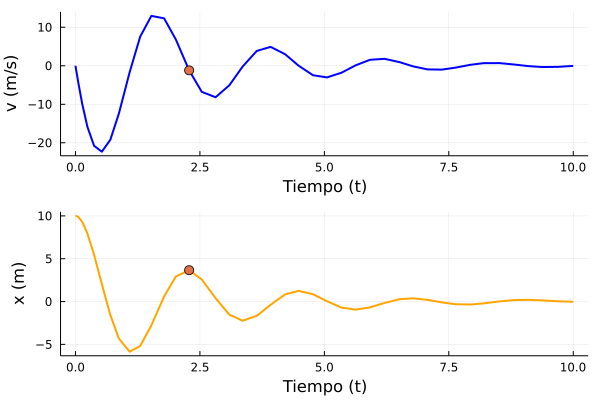

In [17]:
# Paso 3. Analizar la solución
du_sol = [u[1] for u in sol.u]
u_sol = [u[2] for u in sol.u]

v_tiempo = plot(sol.t,
                du_sol,
                linewidth=2,
                xlabel="Tiempo (t)",
                ylabel="v (m/s)",
                color="blue",
                legend=false)

x_tiempo = plot(sol.t,
                u_sol,
                linewidth=2,
                xlabel="Tiempo (t)",
                ylabel="x (m)",
                color="orange",
                legend=false)


plot!(v_tiempo, [sol.t[18]], [du_sol[18]], seriestype=:scatter, m=:circle, ms=5)
plot!(x_tiempo, [sol.t[18]], [u_sol[18]], seriestype=:scatter, m=:circle, ms=5)

dom_tiempo = plot(v_tiempo, x_tiempo, layout=(2,1))

In [18]:
# FFT
# Periodo
T = sol.t[18] # ms

# Cantidad de datos
N = length(du_sol)

# Frecuencia de muestreo
Δf = frec_muestreo(T) # Hz
println("Frecuencia Muestreo: $(Δf) Hz")

# Frecuencia Circular
ω = freq_circular(T) # rad/s
println("Frecuencia Circular: $(ω) rad/s")

Frecuencia Muestreo: 0.4379293882961384 Hz
Frecuencia Circular: 2751.5914981244405 rad/s


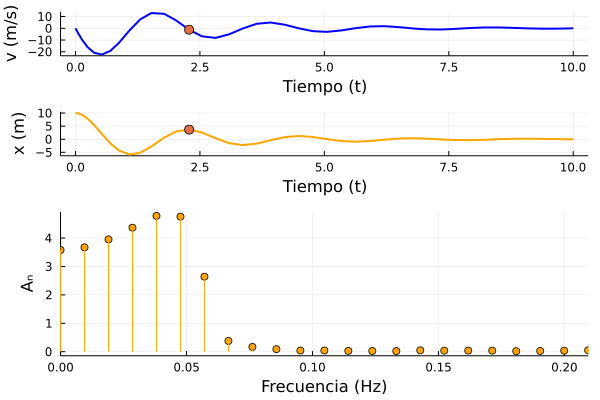

In [19]:
señal = convert(Array{Float64,1}, du_sol) # Any a Float64
señal_fft = fft(señal)

frecs = fftfreq(N, Δf)
Aₙ = (2/N).*abs.(señal_fft)

dom_frec = plot(frecs,
                Aₙ,
                seriestype=:line,
                line=:stem,
                xlabel="Frecuencia (Hz)", 
                ylabel="Aₙ",
                xlim=(0, max(frecs...)),
                legend=false,
                c=:orange,
                m=:circle,
                ms=4)

plot(dom_tiempo, dom_frec, layout=(2,1))

In [20]:
# N-pico de frecuencia máxima
n_pico = argmax(Aₙ)
n_pico

5

In [21]:
# Amplitudes
max_Aₙ = unique(sort(Aₙ, rev=true))[1:n_pico]
max_Aₙ

5-element Vector{Float64}:
 4.7797921792974085
 4.752926239514555
 4.364362289739048
 3.954156990015825
 3.673407764307939

In [22]:
# Ángulos de Fase
ϕ = unique(sort(angle.(señal_fft), rev=true))[1:n_pico]
ϕ

5-element Vector{Float64}:
 3.141592653589793
 3.0376826848095595
 2.967195359290826
 2.807215106235698
 2.507828442396127

## 1.6. Ejemplo 4: Doble Masa - Doble Resorte

<img src='./img/spring2.png' width='600' height='600'/>

Al igual que en el Ejemplo 5, el escenario de una masa-resorte parte de:

$$
F = m a = m \ddot{x}
$$

En donde se tiene presente la Ley de Hooke:

$$
F_s = -k x
$$

En donde:

$$
\sum F_s = m \ddot{x}
$$

Entonces:

$$
\boxed{
\begin{cases}
  m_1 \ddot{x_1} + (k_1 + k_2) x_1 - k_2 x_2 = 0 & (1) \\ 
  \\
  m_2 \ddot{x_2} + k_2 x_2 - k_2 x_1 = 0 & (2) \\
\end{cases}
}
$$

Note que estas ecuaciones pueden ser escritas como:

$$
[M] \ddot{\vec{X}}(t) + [K] \vec{X}(t) = 0
$$

**Nota**: Ejercicio tomado de [aquí](https://www.youtube.com/watch?v=dqtZwZmMh4w).

Modelemos esta ODE de segundo grado para:

- $k_1 = 200$
- $k_2 = 80$
- $m_1 = 10$
- $m_2 = 20$
- $du(t=0) = du_0 = [0, 0]$
- $u(t=0) = u_0 = [0.025, 0.2]$
- $t_{inicial} = 0$
- $t_{final} = 10$

Donde:
- $du$ es la derivada de $u$
- $u$ es la variable que se está resolviendo en estado actual
- $p$ es el parámetro que contiene las variables parametrizadas
- $t$ es el tiempo actual

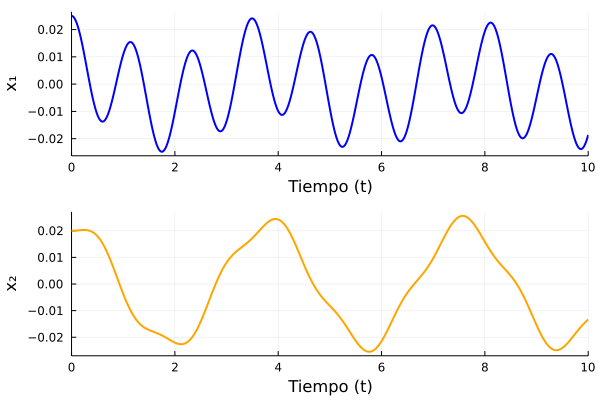

In [23]:
#=
Paso 1. Definir el problema
du[1] -> dx1/dt
du[2] -> dx2/dt

u[1] -> x1
u[2] -> x2
=#
masas2Resortes!(du, u, p, t) = -inv(M)*K*u
    
# Constantes
k₁ = 200.0
k₂ = 80.0
m₁ = 10.0
m₂ = 20.0

K = [k₁+k₂ -k₂;
     -k₂   k₂ ]

M = [m₁ 0 ;
     0  m₂]

# Parámetros
du0 = [0.0, 0.0]
u0 = [0.025, 0.02]
tspan = (0.0, 10.0)

prob = SecondOrderODEProblem(masas2Resortes!, du0, u0, tspan)

# Paso 2. Resolver el problema
sol = solve(prob)

# Paso 3. Analizar la solución
dom_tiempo = plot(sol,
                  vars=[3, 4],
                  linewidth=2,
                  xlabel="Tiempo (t)",
                  ylabel=["x₁" "x₂"],
                  color=["blue" "orange"],
                  legend=false,
                  layout=(2,1))

In [24]:
# FFT
x1_sol = [u[3] for u in sol.u]
x2_sol = [u[4] for u in sol.u]

# Periodo
T_x1 = 3.8 # s
T_x2 = 4 # s

# Cantidad de datos
N = length(sol.u)

# Frecuencia de muestreo
Δf = frec_muestreo(T) # Hz
println("Frecuencia Muestreo: $(Δf) Hz")

# Frecuencia Circular
ω = freq_circular(T) # rad/s
println("Frecuencia Circular: $(ω) rad/s")

Frecuencia Muestreo: 0.4379293882961384 Hz
Frecuencia Circular: 2751.5914981244405 rad/s


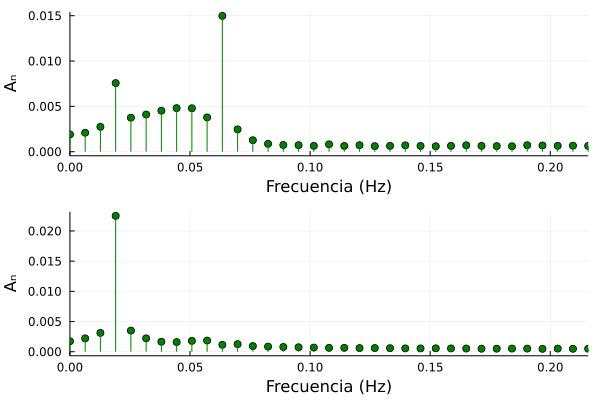

In [25]:
# FFT de X1
señal = convert(Array{Float64,1}, x1_sol) # Any a Float64
señal_fft = fft(señal)

frecs = fftfreq(N, Δf)
Aₙ = (2/N).*abs.(señal_fft)

x1_frec = plot(frecs,
               Aₙ,
               seriestype=:line,
               line=:stem,
               xlabel="Frecuencia (Hz)", 
               ylabel="Aₙ",
               xlim=(0, max(frecs...)),
               legend=false,
               c=:green,
               m=:circle,
               ms=4);

# FFT de X2
señal = convert(Array{Float64,1}, x2_sol) # Any a Float64
señal_fft = fft(señal)

frecs = fftfreq(N, Δf)
Aₙ = (2/N).*abs.(señal_fft)

x2_frec = plot(frecs,
               Aₙ,
               seriestype=:line,
               line=:stem,
               xlabel="Frecuencia (Hz)", 
               ylabel="Aₙ",
               xlim=(0, max(frecs...)),
               legend=false,
               c=:green,
               m=:circle,
               ms=4);

dom_frec = plot(x1_frec, x2_frec, layout=(2,1))

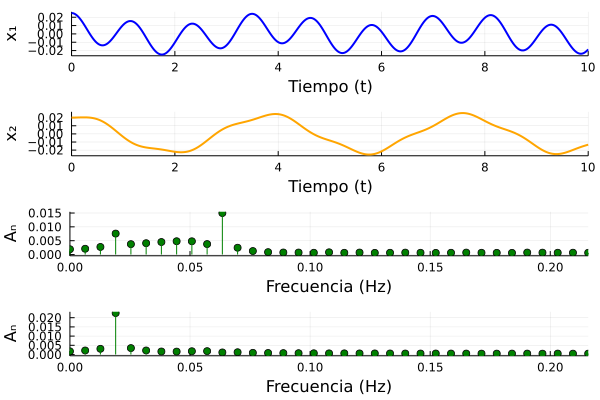

In [26]:
plot(dom_tiempo, dom_frec, layout=(2,1))

## 1.6. Ejemplo 5: Dos Masas - Cinco Resortes

<img src='./img/spring3.png' width='600' height='600'/>

Este ejercicio es una extensión del Ejemplo 4. Lo importante es que veremos cómo se resuelve con notación matricial. Partimos de la siguiente relación:

$$
[M] \ddot{\vec{X}}(t) + [K] \vec{X}(t) = 0
$$

La solución es:

$$
\ddot{\vec{X}}(t) = - [M]^{-1} [K] \vec{X}(t) = 0
$$

Guiándonos de las matrices del Ejemplo 4, podemos intuir que:

$$
[M] =
{\begin{bmatrix}
m_1 & 0 & 0 & 0 \\
0 & m_2 & 0 & 0 \\
0 & 0 & m_3 & 0 \\
0 & 0 & 0 & m_4 \\
\end{bmatrix}}
$$

$$
[K] =
{\begin{bmatrix}
k_1 + k_2 & -k_2 & 0 & 0 \\
-k_2 & k_2 + k_3 & -k_3 & 0 \\
0 & -k_3 & k_3 + k_4 & -k_4 \\
0 & 0 & -k_4 & k_4 + k_5 \\
\end{bmatrix}}
$$

$$
\ddot{x} = 
{\begin{bmatrix}
\ddot{x_1} \\
\ddot{x_2} \\
\ddot{x_3} \\
\ddot{x_4} \\
\end{bmatrix}}
$$

$$
x = 
{\begin{bmatrix}
x_1 \\
x_2 \\
x_3 \\
x_4 \\
\end{bmatrix}}
$$

**Nota**: Ejercicio tomado de [aquí](https://quasiengineer.dev/tech/engg/solving-2nd-order-odes-in-julia/).

Modelemos esta ODE de segundo grado para:

- $m_1 = m_2 = m_3 = m_4 = 5$
- $k_1 = k_2 = k_3 = k_4 = 5$
- $k_5 = 0$
- $du(t=0) = du_0 = [0, 0, 0, 0]$ para $m_1, m_2, m_3, m_4$
- $u(t=0) = u_0 = [0.025, 0.02, 0.02, 0.001]$ para $m_1, m_2, m_3, m_4$
- $t_{inicial} = 0$
- $t_{final} = 200$

Donde:
- $du$ es la derivada de $u$
- $u$ es la variable que se está resolviendo en estado actual
- $p$ es el parámetro que contiene las variables parametrizadas
- $t$ es el tiempo actual

In [27]:
# Paso 1. Definir el problema
masas5Resortes!(du, u, p, t) = -inv(M)*K*u

# Constantes
m₁, m₂, m₃, m₄ = 5, 5, 5, 5

M = [m₁  0   0   0;
     0   m₂  0   0;
     0   0   m₃  0;
     0   0   0   m₄]

M

4×4 Matrix{Int64}:
 5  0  0  0
 0  5  0  0
 0  0  5  0
 0  0  0  5

In [28]:
k₁, k₂, k₃, k₄, k₅ = 5, 5, 5, 5, 0

K = [k₁+k₂ -k₂   0     0;
     -k₂   k₂+k₃ -k₃   0;
     0     -k₃   k₃+k₄ -k₄;
     0     0     -k₄   k₄+k₅]
K

4×4 Matrix{Int64}:
 10  -5   0   0
 -5  10  -5   0
  0  -5  10  -5
  0   0  -5   5

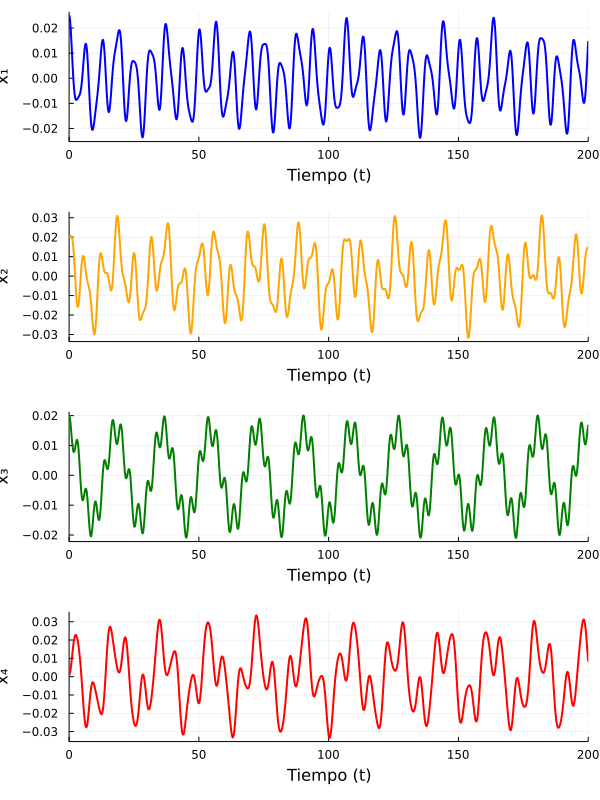

In [29]:
# Parámetros
du0 = zeros(4)
u0 = [0.025, 0.02, 0.02, 0.001]
tspan = (0.0, 200.0)

prob = SecondOrderODEProblem(masas5Resortes!,du0,u0,tspan)

# Paso 2. Resolver el problema
sol = solve(prob)

# Paso 3. Analizar la solución
plot(sol,
     vars=[5, 6, 7, 8],
     linewidth=2,
     xlabel="Tiempo (t)",
     ylabel=["x₁" "x₂" "x₃" "x₄"],
     color=["blue" "orange" "green" "red"],
     legend=false,
     layout=(4,1),
     size=(600, 800))

In [30]:
# FFT
x1_sol = [u[5] for u in sol.u]
x2_sol = [u[6] for u in sol.u]
x3_sol = [u[7] for u in sol.u]
x4_sol = [u[8] for u in sol.u]

# Periodo
T_x1 = 20 # s
T_x2 = 20 # s
T_x3 = 20 # s
T_x4 = 20 # s

# Cantidad de datos
N = length(sol.u)

# Frecuencia de muestreo
Δf = frec_muestreo(T) # Hz
println("Frecuencia Muestreo: $(Δf) Hz")

# Frecuencia Circular
ω = freq_circular(T) # rad/s
println("Frecuencia Circular: $(ω) rad/s")

Frecuencia Muestreo: 0.4379293882961384 Hz
Frecuencia Circular: 2751.5914981244405 rad/s


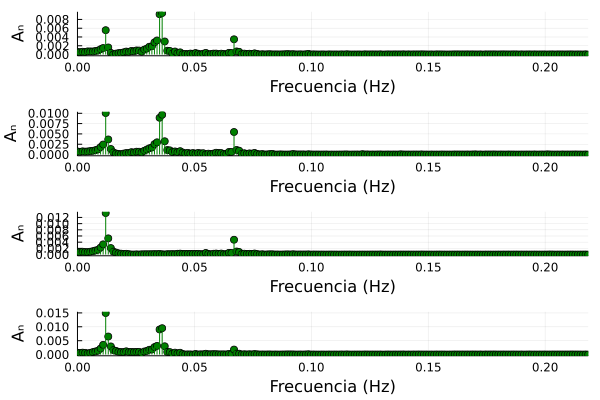

In [31]:
#### FFT de X1
señal = convert(Array{Float64,1}, x1_sol) # Any a Float64
señal_fft = fft(señal)

frecs = fftfreq(N, Δf)
Aₙ = (2/N).*abs.(señal_fft)

x1_frec = plot(frecs,
               Aₙ,
               seriestype=:line,
               line=:stem,
               xlabel="Frecuencia (Hz)", 
               ylabel="Aₙ",
               xlim=(0, max(frecs...)),
               legend=false,
               c=:green,
               m=:circle,
               ms=4);

# FFT de X2
señal = convert(Array{Float64,1}, x2_sol) # Any a Float64
señal_fft = fft(señal)

frecs = fftfreq(N, Δf)
Aₙ = (2/N).*abs.(señal_fft)

x2_frec = plot(frecs,
               Aₙ,
               seriestype=:line,
               line=:stem,
               xlabel="Frecuencia (Hz)", 
               ylabel="Aₙ",
               xlim=(0, max(frecs...)),
               legend=false,
               c=:green,
               m=:circle,
               ms=4);

# FFT de X3
señal = convert(Array{Float64,1}, x3_sol) # Any a Float64
señal_fft = fft(señal)

frecs = fftfreq(N, Δf)
Aₙ = (2/N).*abs.(señal_fft)

x3_frec = plot(frecs,
               Aₙ,
               seriestype=:line,
               line=:stem,
               xlabel="Frecuencia (Hz)", 
               ylabel="Aₙ",
               xlim=(0, max(frecs...)),
               legend=false,
               c=:green,
               m=:circle,
               ms=4);

# FFT de X4
señal = convert(Array{Float64,1}, x4_sol) # Any a Float64
señal_fft = fft(señal)

frecs = fftfreq(N, Δf)
Aₙ = (2/N).*abs.(señal_fft)

x4_frec = plot(frecs,
               Aₙ,
               seriestype=:line,
               line=:stem,
               xlabel="Frecuencia (Hz)", 
               ylabel="Aₙ",
               xlim=(0, max(frecs...)),
               legend=false,
               c=:green,
               m=:circle,
               ms=4);

dom_frec = plot(x1_frec, x2_frec, x3_frec, x4_frec, layout=(4,1))